In [3]:
import numpy as np
import pandas as pd
import os

! pip install catboost
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download grubenm/austin-weather
! unzip austin-weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/28.8k [00:00<?, ?B/s]
100% 28.8k/28.8k [00:00<00:00, 3.73MB/s]
Archive:  austin-weather.zip
  inflating: austin_weather.csv      


## Load and preprocess data

In [4]:
data = pd.read_csv('austin_weather.csv', parse_dates=['Date'])
print('DATA SHAPE: {}'.format(data.shape))
print('------------------------------------------------------------------')
print('FEATURES LIST AND TYPES:\n{}'.format(data.dtypes))
print('------------------------------------------------------------------')
print('NUMBER OF NaNs PER FEATURE:\n{}'.format(data.isnull().sum(axis=0)))
data.head(3)

DATA SHAPE: (1319, 21)
------------------------------------------------------------------
FEATURES LIST AND TYPES:
Date                          datetime64[ns]
TempHighF                              int64
TempAvgF                               int64
TempLowF                               int64
DewPointHighF                         object
DewPointAvgF                          object
DewPointLowF                          object
HumidityHighPercent                   object
HumidityAvgPercent                    object
HumidityLowPercent                    object
SeaLevelPressureHighInches            object
SeaLevelPressureAvgInches             object
SeaLevelPressureLowInches             object
VisibilityHighMiles                   object
VisibilityAvgMiles                    object
VisibilityLowMiles                    object
WindHighMPH                           object
WindAvgMPH                            object
WindGustMPH                           object
PrecipitationSumInches        

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,


In [5]:
# data cleaning and preprocessing
# replacing ' ' with 'Clear'
data['Events'] = data['Events'].replace(' ', 'Clear')

# adding feature 'DayOfYear'
days_of_year = [date.dayofyear for date in data['Date']]
data['DayOfYear'] = days_of_year

from sklearn.impute import SimpleImputer
data = data.replace('-', float('NaN'))
# 'T' means trace precipitation, so replace it with a 'slightly above 0' number
data['PrecipitationSumInches'] = data['PrecipitationSumInches'].replace('T', 0.0005)
imputed_columns = list(set(data.columns)-set(['Date', 'Events']))
imputer = SimpleImputer(missing_values=float('NaN'), strategy='mean')
data[imputed_columns] = imputer.fit_transform(data[imputed_columns])

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaled_data = data.copy()
to_be_scaled = list(set(data.columns)-set(['Date', 'Events']))
scaler = MinMaxScaler()
scaler.fit(data[to_be_scaled])
scaled_data[to_be_scaled] = scaler.transform(data[to_be_scaled])

In [7]:
# encoding labels
from sklearn.preprocessing import LabelEncoder

# encoding
preprocessed_data = scaled_data
encoder = LabelEncoder()
encoder.fit(scaled_data['Events'])
preprocessed_data['Events'] = encoder.transform(scaled_data['Events'])

# printing
classes_occurrences = preprocessed_data['Events'].value_counts().to_frame()
classes_occurrences['Class'] = encoder.inverse_transform(classes_occurrences.index)
classes_occurrences = classes_occurrences.sort_index(axis=0)
print(classes_occurrences)

   Events                      Class
0     903                      Clear
1      21                        Fog
2      14                 Fog , Rain
3      33  Fog , Rain , Thunderstorm
4       1         Fog , Thunderstorm
5     192                       Rain
6       1                Rain , Snow
7     137        Rain , Thunderstorm
8      17               Thunderstorm


In [8]:
# relabeling
preprocessed_data['Events'] = preprocessed_data['Events'].replace([1], 0)
preprocessed_data['Events'] = preprocessed_data['Events'].replace([2,5,6], 1)
preprocessed_data['Events'] = preprocessed_data['Events'].replace([3,4,7,8], 2)

# printing classes and number of occurrences
classes_occurrences = preprocessed_data['Events'].value_counts().to_frame()
classes_occurrences['Class'] = ['Clear', 'Rain', 'Thunderstorm']
classes_occurrences = classes_occurrences.sort_index(axis=0)
print(classes_occurrences)

   Events         Class
0     924         Clear
1     207          Rain
2     188  Thunderstorm


# Helper Functions

In [9]:
! pip install openml
import openml
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow import keras
import itertools
import time
import numpy as np
from sklearn.model_selection import cross_val_score

def import_data():
    # Load the precipitation data
    X1 = preprocessed_data[set(list(preprocessed_data.columns))-set(['Events', 'Date'])]
    y1  = preprocessed_data['Events']
    X1 = X1.astype("float32")
    y1 = y1.astype("float32")

    # Load the PhishingWebsites dataset from OpenML
    phishing = openml.datasets.get_dataset(4534)
    X2, y2, categorical_indicator, attribute_names = phishing.get_data(
        target=phishing.default_target_attribute,
    )

    X2 = X2.astype("float32")
    y2 = y2.astype("float32")
    return X1, y1, X2, y2

# Define a function to fit the model and return the accuracy
def fit_and_score(model, X, y, train_sizes):
    train_scores = []
    validation_scores = []
    training_times = []
    prediction_times = []
    for size in train_sizes:
        X_train = X[:int(size * X.shape[0])]
        y_train = y[:int(size * X.shape[0])]
        # Measure the traning time
        start_time = time.time()
        model.fit(X_train, y_train)
        training_times.append(time.time() - start_time)
        y_pred = model.predict(X_train)
        f1_train = f1_score(y_train, y_pred, average='macro')
        # training score
        train_scores.append(f1_train)
        # validation score
        f1_cv = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro'))
        validation_scores.append(f1_cv)
        # Measure the prediction time
        start_time = time.time()
        model.predict(X_test)
        prediction_times.append(time.time() - start_time)
        print(prediction_times)

    return train_scores, validation_scores, training_times, prediction_times

def plot_learning_curve(model, X, y, title1, title2):
    # Obtain the learning curve
    train_sizes = np.linspace(0.1, 0.9, 9)
    train_scores, validation_scores, training_times, prediction_times = fit_and_score(model, X, y, train_sizes)

    # Plot the learning curve
    plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, validation_scores, 'o-', color='g', label='Validation score')
    plt.xlabel('Training data size')
    plt.ylabel('Model F1 score')
    plt.legend(loc='best')
    plt.savefig(title1)
    plt.show()

    # Plot the training and prediction times as a function of training data size
    plt.plot(train_sizes, training_times, label='Training Time')
    plt.plot(train_sizes, prediction_times, label='Prediction Time')
    plt.xlabel('Training Data Size')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.savefig(title2)
    plt.show()

    return training_times, prediction_times


def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):  
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    start_time = time.time()   
    y_pred = clf.predict(X_test)
    end_time = time.time()
    pred_time = end_time - start_time
    
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='macro')
    recall = recall_score(y_test,y_pred, average='macro')

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    return f1, accuracy, precision, recall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=a099bb28c3d150fe2fcfcd3f8912fd9e8ad8b46475cabaf678fce720c8518d2a
  Stored in directory: /root/.cache/pip/wheels/a2/de/68/bf3972de3ecb31e32bef59a7f4c75f0687a3674c476b347c14
Successfully built liac-arff


# Neural Network

In [14]:
# plot model F1 score as a funciton of No. of hidden units
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

def parameters_NN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,100,10).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.1, random_state=100, max_iter=500, alpha=0.1)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test, average='macro'))
            f1_train.append(f1_score(y_train, y_pred_train, average='macro'))
      
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',max_iter=500, alpha=0.1, random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

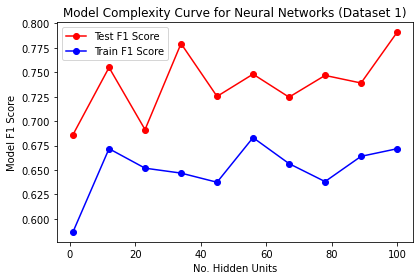

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 5, 'learning_rate_init': 0.01}


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.001234292984008789, 0.000978708267211914]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344, 0.0011053085327148438]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344, 0.0011053085327148438, 0.001264810562133789]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344, 0.0011053085327148438, 0.001264810562133789, 0.0010867118835449219]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344, 0.0011053085327148438, 0.001264810562133789, 0.0010867118835449219, 0.0011947154998779297]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344, 0.0011053085327148438, 0.001264810562133789, 0.0010867118835449219, 0.0011947154998779297, 0.0011887550354003906]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.001234292984008789, 0.000978708267211914, 0.0012259483337402344, 0.0011053085327148438, 0.001264810562133789, 0.0010867118835449219, 0.0011947154998779297, 0.0011887550354003906, 0.0013911724090576172]


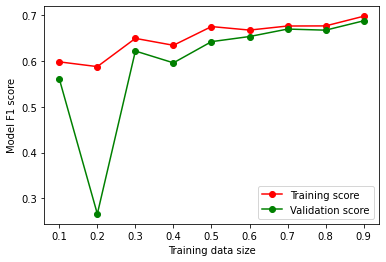

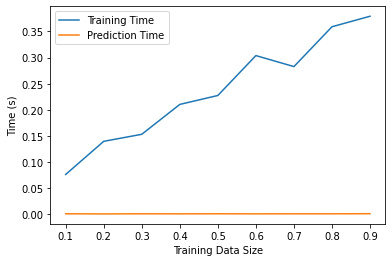

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.44611
Model Prediction Time (s): 0.00146

F1 Score:  0.76
Accuracy:  0.88
Precision: 0.80     Recall:    0.74
*****************************************************


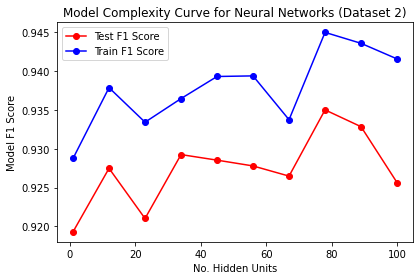

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 30, 'learning_rate_init': 0.01}


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438, 0.002870321273803711]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438, 0.002870321273803711, 0.002588033676147461]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438, 0.002870321273803711, 0.002588033676147461, 0.0026199817657470703]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438, 0.002870321273803711, 0.002588033676147461, 0.0026199817657470703, 0.0025975704193115234]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438, 0.002870321273803711, 0.002588033676147461, 0.0026199817657470703, 0.0025975704193115234, 0.002610921859741211]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.0028314590454101562, 0.0035393238067626953, 0.0027532577514648438, 0.002870321273803711, 0.002588033676147461, 0.0026199817657470703, 0.0025975704193115234, 0.002610921859741211, 0.002599000930786133]


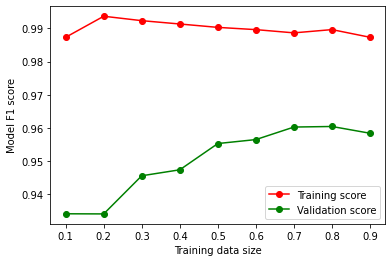

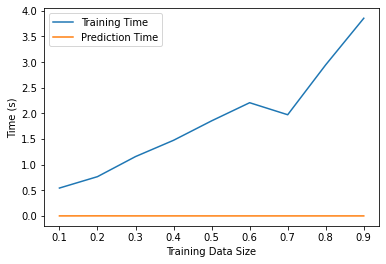

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   3.02078
Model Prediction Time (s): 0.00313

F1 Score:  0.97
Accuracy:  0.97
Precision: 0.97     Recall:    0.97
*****************************************************


In [15]:
X1,y1,X2,y2 = import_data()

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=0)
parameters_NN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Neural Networks (Dataset 1)")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)
clf_dataset1 = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
training_times_nn_1, prediction_times_nn_1 = plot_learning_curve(clf_dataset1, X_train, y_train, "F1_dataset1_size_nn", "time_dataset1_size_nn")
f1_nn_1, accuracy_nn_1, precision_nn_1, recall_nn_1 = final_classifier_evaluation(clf_dataset1, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=0.20, random_state=0)
parameters_NN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Neural Networks (Dataset 2)")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)
clf_dataset2 = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
training_times_nn_2, prediction_times_nn_2 = plot_learning_curve(clf_dataset2, X_train, y_train, "F1_dataset2_size_nn", "time_dataset2_size_nn")
f1_nn_2, accuracy_nn_2, precision_nn_2, recall_nn_2 = final_classifier_evaluation(clf_dataset2, X_train, X_test, y_train, y_test)

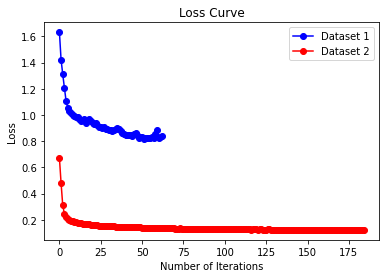

In [26]:
X1, y1, X2, y2 = import_data()

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state = 0)
clf_dataset1 = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', 
                               learning_rate_init=0.05, random_state=100)
clf_dataset1.fit(X_train, y_train)
loss_curve1 = clf_dataset1.loss_curve_

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20)
clf_dataset2 = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', 
                               learning_rate_init=0.01, random_state=100)
clf_dataset2.fit(X_train, y_train)
loss_curve2 = clf_dataset2.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(loss_curve1, 'o-', color="b", label="Dataset 1")
plt.plot(loss_curve2, 'o-', color="r", label="Dataset 2")
plt.legend(loc="best")
plt.savefig("loss_curve_nn.png")
plt.show()

## Support Vector Machine

In [10]:
from sklearn.svm import SVC

def parameters_SVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j, random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test, average = 'macro'))
                    f1_train.append(f1_score(y_train, y_pred_train, average = 'macro'))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test, average = 'macro'))
                f1_train.append(f1_score(y_train, y_pred_train, average = 'macro'))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    Cs = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gammas = [1,10,100]
    param_grid = {'C': Cs, 'gamma': gammas}

    clf = GridSearchCV(estimator = SVC(kernel = "linear", random_state=100),
                       param_grid=param_grid, cv=10)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['gamma']

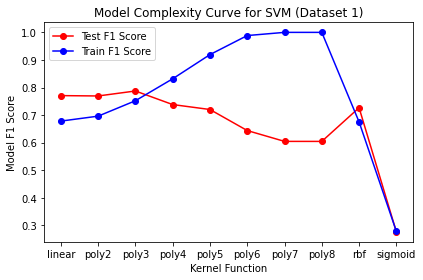

Per Hyperparameter tuning, best parameters are:
{'C': 10.0, 'gamma': 1}
[0.0018398761749267578]
[0.0018398761749267578, 0.0016129016876220703]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797, 0.0021719932556152344]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797, 0.0021719932556152344, 0.002257108688354492]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797, 0.0021719932556152344, 0.002257108688354492, 0.0028696060180664062]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797, 0.0021719932556152344, 0.002257108688354492, 0.0028696060180664062, 0.002724170684814453]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797, 0.0021719932556152344, 0.002257108688354492, 0.0028696060180664062, 0.002724170684814453, 0.003481149673461914]
[0.0018398761749267578, 0.0016129016876220703, 0.0019347667694091797, 0.0021719932556152344, 0.0022

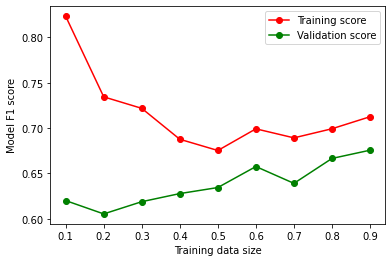

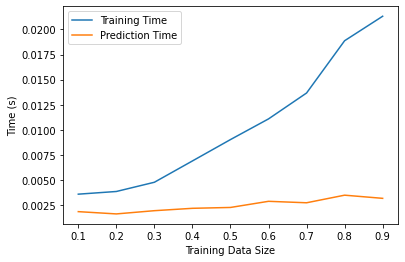

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.04944
Model Prediction Time (s): 0.00641

F1 Score:  0.78
Accuracy:  0.88
Precision: 0.83     Recall:    0.74
*****************************************************


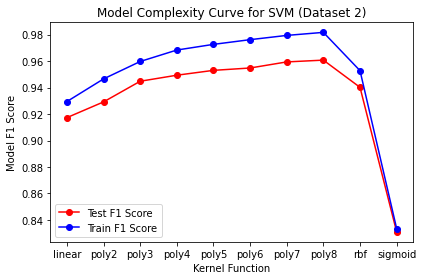

Per Hyperparameter tuning, best parameters are:
{'C': 1, 'gamma': 1}
[0.035791635513305664]
[0.035791635513305664, 0.06223154067993164]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598, 0.0952303409576416]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598, 0.0952303409576416, 0.11640620231628418]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598, 0.0952303409576416, 0.11640620231628418, 0.1332569122314453]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598, 0.0952303409576416, 0.11640620231628418, 0.1332569122314453, 0.1366593837738037]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598, 0.0952303409576416, 0.11640620231628418, 0.1332569122314453, 0.1366593837738037, 0.14997339248657227]
[0.035791635513305664, 0.06223154067993164, 0.07856392860412598, 0.0952303409576416, 0.11640620231628418, 0.1332569122314453, 0.1366593837738037, 0.14997339248657227, 0.

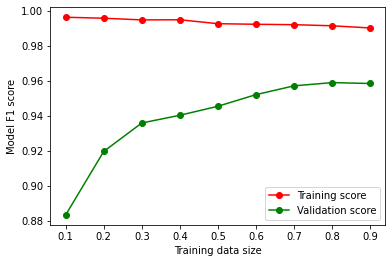

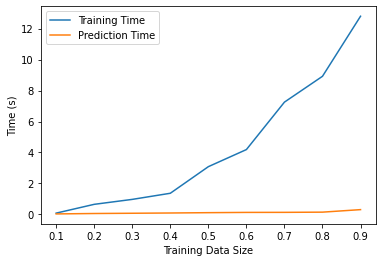

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   16.13878
Model Prediction Time (s): 0.17114

F1 Score:  0.97
Accuracy:  0.97
Precision: 0.97     Recall:    0.97
*****************************************************


In [13]:
X1,y1,X2,y2 = import_data()

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=0)
parameters_SVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Dataset 1)")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)
clf_dataset1 = SVC(C=C_val, gamma=gamma_val, kernel='linear', random_state=100)
training_times_svm_1, prediction_times_svm_1 = plot_learning_curve(clf_dataset1, X_train, y_train, "F1_dataset1_size_svm", "time_dataset1_size_svm")
f1_svm_1, accuracy_svm_1, precision_svm_1, recall_svm_1 = final_classifier_evaluation(clf_dataset1, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=0.20, random_state=0)
parameters_SVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Dataset 2)")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)
clf_dataset2 = SVC(C=C_val, gamma=gamma_val, kernel='poly', degree = 8, random_state=100)
training_times_svm_2, prediction_times_svm_2 = plot_learning_curve(clf_dataset2, X_train, y_train, "F1_dataset2_size_svm", "time_dataset2_size_svm")
f1_svm_2, accuracy_svm_2, precision_svm_2, recall_svm_2 = final_classifier_evaluation(clf_dataset2, X_train, X_test, y_train, y_test)

## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

def parameters_DT(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=5, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test, average = "macro"))
            f1_train.append(f1_score(y_train, y_pred_train, average = "macro"))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
     
    
def DTGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10, scoring = "f1_macro")
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']

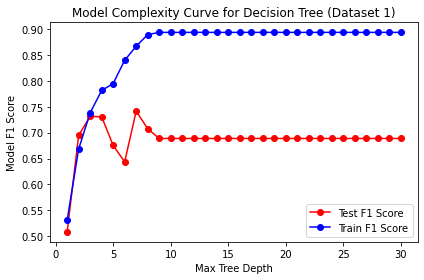

Per Hyperparameter tuning, best parameters are:
{'max_depth': 6, 'min_samples_leaf': 5}
[0.0013048648834228516]
[0.0013048648834228516, 0.0014040470123291016]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078, 0.0011756420135498047]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078, 0.0011756420135498047, 0.001874685287475586]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078, 0.0011756420135498047, 0.001874685287475586, 0.0016453266143798828]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078, 0.0011756420135498047, 0.001874685287475586, 0.0016453266143798828, 0.0012116432189941406]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078, 0.0011756420135498047, 0.001874685287475586, 0.0016453266143798828, 0.0012116432189941406, 0.00116729736328125]
[0.0013048648834228516, 0.0014040470123291016, 0.0012829303741455078, 0.0011756420

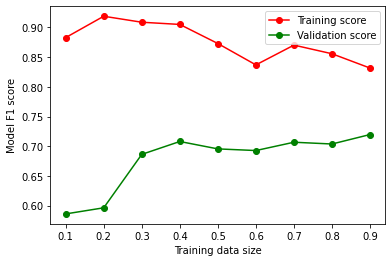

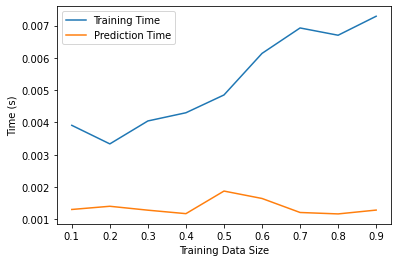

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.01169
Model Prediction Time (s): 0.00192

F1 Score:  0.64
Accuracy:  0.81
Precision: 0.64     Recall:    0.65
*****************************************************


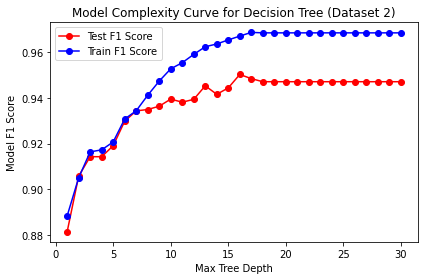

Per Hyperparameter tuning, best parameters are:
{'max_depth': 9, 'min_samples_leaf': 44}
[0.0011658668518066406]
[0.0011658668518066406, 0.00141143798828125]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781, 0.001215219497680664]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781, 0.001215219497680664, 0.001104593276977539]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781, 0.001215219497680664, 0.001104593276977539, 0.00133514404296875]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781, 0.001215219497680664, 0.001104593276977539, 0.00133514404296875, 0.0020084381103515625]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781, 0.001215219497680664, 0.001104593276977539, 0.00133514404296875, 0.0020084381103515625, 0.0016207695007324219]
[0.0011658668518066406, 0.00141143798828125, 0.0010952949523925781, 0.001215219497680664, 0.001104593276

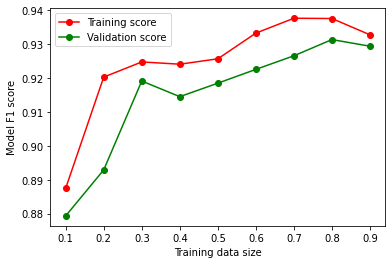

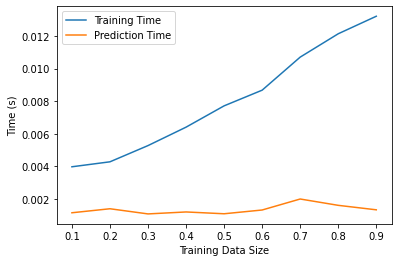

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.01907
Model Prediction Time (s): 0.00175

F1 Score:  0.93
Accuracy:  0.93
Precision: 0.93     Recall:    0.93
*****************************************************


In [17]:
X1,y1,X2,y2 = import_data()

X_train, X_test, y_train, y_test = train_test_split(X1,y1, test_size=0.20, random_state = 0)
parameters_DT(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (Dataset 1)")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf = DTGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
clf_dataset1 = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
training_times_dt_1, prediction_times_dt_1 = plot_learning_curve(clf_dataset1, X_train, y_train, "F1_dataset1_size_dt", "time_dataset1_size_dt")
f1_dt_1, accuracy_dt_1, precision_dt_1, recall_dt_1 = final_classifier_evaluation(clf_dataset1, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=0.20, random_state = 0)
parameters_DT(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (Dataset 2)")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf = DTGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
clf_dataset2 = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
training_times_dt_2, prediction_times_dt_2 = plot_learning_curve(clf_dataset2, X_train, y_train, "F1_dataset2_size_dt", "time_dataset2_size_dt")
f1_dt_2, accuracy_dt_2, precision_dt_2, recall_dt_2 = final_classifier_evaluation(clf_dataset2, X_train, X_test, y_train, y_test)

## Boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

def parameters_Boost(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), 
                                             min_samples_leaf=int(min_samples_leaf/2), random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test, average = "macro"))
            f1_train.append(f1_score(y_train, y_pred_train, average = "macro"))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

def BoostGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #n_estimators, learning_rate, max_depth, min_samples_leaf
    param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),
                  'max_depth': np.arange(1,4),
                  'n_estimators': np.linspace(10,100,3).round().astype('int'),
                  'learning_rate': np.linspace(.001,.1,3)}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['max_depth'], boost.best_params_['min_samples_leaf'], boost.best_params_['n_estimators'], boost.best_params_['learning_rate']

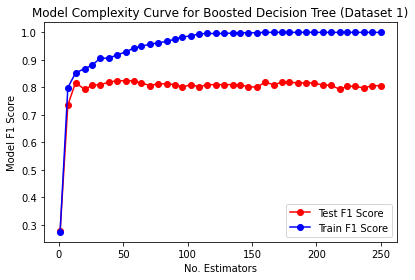

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 55}
[0.0019686222076416016]
[0.0019686222076416016, 0.0020589828491210938]
[0.0019686222076416016, 0.0020589828491210938, 0.002100706100463867]
[0.0019686222076416016, 0.0020589828491210938, 0.002100706100463867, 0.002055644989013672]
[0.0019686222076416016, 0.0020589828491210938, 0.002100706100463867, 0.002055644989013672, 0.0026760101318359375]
[0.0019686222076416016, 0.0020589828491210938, 0.002100706100463867, 0.002055644989013672, 0.0026760101318359375, 0.002521514892578125]
[0.0019686222076416016, 0.0020589828491210938, 0.002100706100463867, 0.002055644989013672, 0.0026760101318359375, 0.002521514892578125, 0.0021371841430664062]
[0.0019686222076416016, 0.0020589828491210938, 0.002100706100463867, 0.002055644989013672, 0.0026760101318359375, 0.002521514892578125, 0.0021371841430664062, 0.0022177696228027344]
[0.0019686222076416016, 0.0020589828491210938, 0

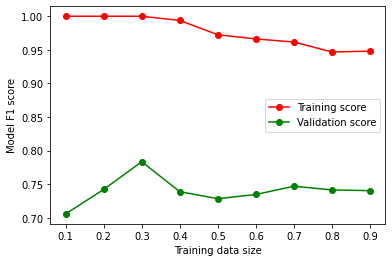

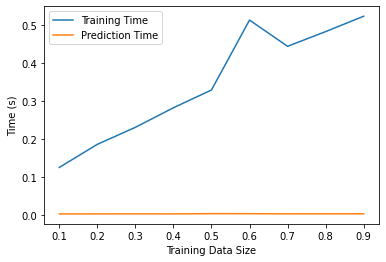

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.57120
Model Prediction Time (s): 0.00235

F1 Score:  0.82
Accuracy:  0.90
Precision: 0.82     Recall:    0.81
*****************************************************


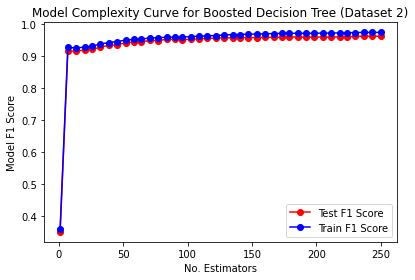

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 44, 'n_estimators': 100}
[0.006091117858886719]
[0.006091117858886719, 0.006047248840332031]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125, 0.00595855712890625]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125, 0.00595855712890625, 0.005779266357421875]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125, 0.00595855712890625, 0.005779266357421875, 0.006725788116455078]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125, 0.00595855712890625, 0.005779266357421875, 0.006725788116455078, 0.005799531936645508]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125, 0.00595855712890625, 0.005779266357421875, 0.006725788116455078, 0.005799531936645508, 0.006188869476318359]
[0.006091117858886719, 0.006047248840332031, 0.0069293975830078125,

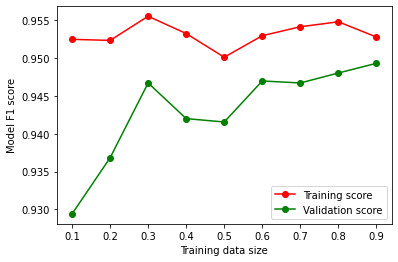

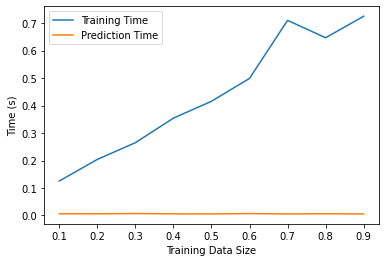

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.01242
Model Prediction Time (s): 0.00718

F1 Score:  0.94
Accuracy:  0.95
Precision: 0.95     Recall:    0.94
*****************************************************


In [19]:
X1,y1,X2,y2 = import_data()

X_train, X_test, y_train, y_test = train_test_split(X1,y1, test_size=0.20, random_state = 0)
parameters_Boost(X_train, y_train, X_test, y_test, 6, 5, title="Model Complexity Curve for Boosted Decision Tree (Dataset 1)")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf, n_estimators, learning_rate = BoostGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
clf_dataset1 = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, learning_rate = learning_rate, random_state=100)
training_times_bt_1, prediction_times_bt_1 = plot_learning_curve(clf_dataset1, X_train, y_train, "F1_dataset1_size_boosted", "time_dataset1_size_boosted")
f1_bt_1, accuracy_bt_1, precision_bt_1, recall_bt_1 = final_classifier_evaluation(clf_dataset1, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=0.20, random_state = 0)
parameters_Boost(X_train, y_train, X_test, y_test, 9, 44, title="Model Complexity Curve for Boosted Decision Tree (Dataset 2)")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train))
max_depth, min_samples_leaf, n_estimators, learning_rate = BoostGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
clf_dataset2 = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, learning_rate = learning_rate, random_state=100)
training_times_bt_2, prediction_times_bt_2 = plot_learning_curve(clf_dataset2, X_train, y_train, "F1_dataset2_size_boosted", "time_dataset2_size_boosted")
f1_bt_2, accuracy_bt_2, precision_bt_2, recall_bt_2 = final_classifier_evaluation(clf_dataset2, X_train, X_test, y_train, y_test)

## K-Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier as kNN

def parameters_KNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test, average = "macro"))
        f1_train.append(f1_score(y_train, y_pred_train, average = "macro"))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(title)
    plt.show()

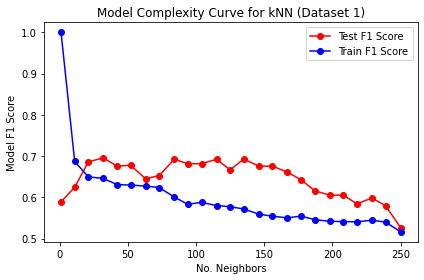

[0.01683974266052246]
[0.01683974266052246, 0.014753580093383789]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617, 0.015657901763916016]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617, 0.015657901763916016, 0.015769004821777344]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617, 0.015657901763916016, 0.015769004821777344, 0.01875901222229004]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617, 0.015657901763916016, 0.015769004821777344, 0.01875901222229004, 0.01679253578186035]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617, 0.015657901763916016, 0.015769004821777344, 0.01875901222229004, 0.01679253578186035, 0.017368078231811523]
[0.01683974266052246, 0.014753580093383789, 0.018542051315307617, 0.015657901763916016, 0.015769004821777344, 0.01875901222229004, 0.01679253578186035, 0.017368078231811523, 0.01779460906982422]


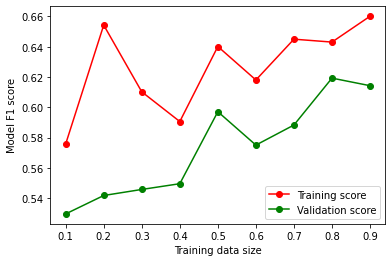

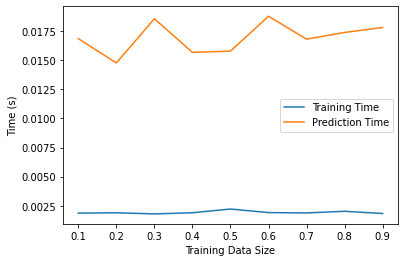

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00273
Model Prediction Time (s): 0.02528

F1 Score:  0.69
Accuracy:  0.84
Precision: 0.76     Recall:    0.65
*****************************************************


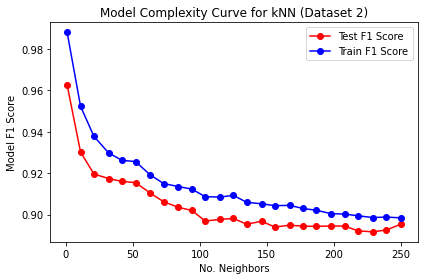

[0.1598978042602539]
[0.1598978042602539, 0.13534331321716309]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211, 0.20696139335632324]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211, 0.20696139335632324, 0.23366165161132812]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211, 0.20696139335632324, 0.23366165161132812, 0.31226420402526855]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211, 0.20696139335632324, 0.23366165161132812, 0.31226420402526855, 0.3748304843902588]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211, 0.20696139335632324, 0.23366165161132812, 0.31226420402526855, 0.3748304843902588, 0.3180074691772461]
[0.1598978042602539, 0.13534331321716309, 0.1927328109741211, 0.20696139335632324, 0.23366165161132812, 0.31226420402526855, 0.3748304843902588, 0.3180074691772461, 0.5042781829833984]


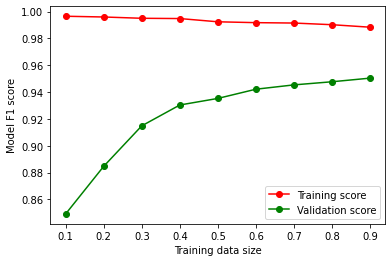

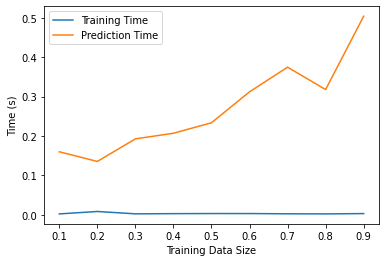

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00335
Model Prediction Time (s): 0.37052

F1 Score:  0.96
Accuracy:  0.96
Precision: 0.96     Recall:    0.96
*****************************************************


In [21]:
X1, y1, X2, y2 = import_data()

X_train, X_test, y_train, y_test = train_test_split(X1,y1, test_size=0.20, random_state = 0)
parameters_KNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (Dataset 1)")
clf_dataset1 = kNN(n_neighbors=20, n_jobs=-1)
training_times_knn_1, prediction_times_knn_1 = plot_learning_curve(clf_dataset1, X_train, y_train, "F1_dataset1_size_knn", "time_dataset1_size_knn")
f1_knn_1, accuracy_knn_1, precision_knn_1, recall_knn_1 = final_classifier_evaluation(clf_dataset1, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=0.20, random_state = 0)
parameters_KNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (Dataset 2)")
clf_dataset2 = kNN(n_neighbors=1, n_jobs=-1)
training_times_knn_2, prediction_times_knn_2 = plot_learning_curve(clf_dataset2, X_train, y_train, "F1_dataset2_size_knn", "time_dataset2_size_knn")
f1_knn_2, accuracy_knn_2, precision_knn_2, recall_knn_2 = final_classifier_evaluation(clf_dataset2, X_train, X_test, y_train, y_test)

In [22]:
def compare_training_time(n,NN_train_time, SVM_train_time, KNN_train_time, DT_train_time, BT_train_time, title): 
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NN_train_time, '-', color="b", label="Neural Network")
    plt.plot(n, SVM_train_time, '-', color="r", label="SVM")
    plt.plot(n, KNN_train_time, '-', color="g", label="KNN")
    plt.plot(n, DT_train_time, '-', color="m", label="Decision Tree")
    plt.plot(n, BT_train_time, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.savefig(title)
    plt.show()
    
def compare_prediction_time(n,NN_pred_time, SVM_pred_time, KNN_pred_time, DT_pred_time, BT_pred_time, title):   
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NN_pred_time, '-', color="b", label="Neural Network")
    plt.plot(n, SVM_pred_time, '-', color="r", label="SVM")
    plt.plot(n, KNN_pred_time, '-', color="g", label="KNN")
    plt.plot(n, DT_pred_time, '-', color="m", label="Decision Tree")
    plt.plot(n, BT_pred_time, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.savefig(title)
    plt.show()


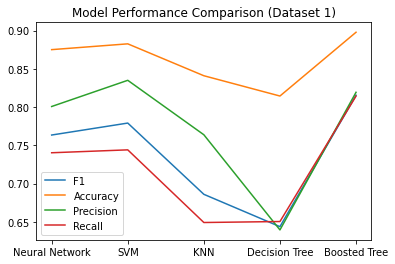

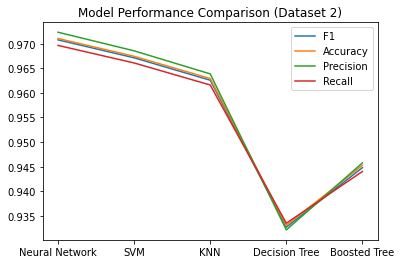

In [23]:
import pandas as pd
models = ["Neural Network", "SVM", "KNN", "Decision Tree", "Boosted Tree"]
f1_1 = [f1_nn_1, f1_svm_1, f1_knn_1, f1_dt_1, f1_bt_1]
accuracy_1 = [accuracy_nn_1, accuracy_svm_1, accuracy_knn_1, accuracy_dt_1, accuracy_bt_1]
precision_1 = [precision_nn_1, precision_svm_1, precision_knn_1, precision_dt_1, precision_bt_1]
recall_1 = [recall_nn_1, recall_svm_1, recall_knn_1, recall_dt_1, recall_bt_1]
array = np.column_stack((f1_1, accuracy_1, precision_1, recall_1))
dataframe_1 = pd.DataFrame(array, index = models, columns = ["F1", "Accuracy", "Precision", "Recall"])

plt.figure()
plt.plot(dataframe_1)
plt.legend(["F1", "Accuracy", "Precision", "Recall"], loc = "best")
plt.title("Model Performance Comparison (Dataset 1)")
plt.savefig("Model Performance (Dataset 1)")
plt.show()


f1_2 = [f1_nn_2, f1_svm_2, f1_knn_2, f1_dt_2, f1_bt_2]
accuracy_2 = [accuracy_nn_2, accuracy_svm_2, accuracy_knn_2, accuracy_dt_2, accuracy_bt_2]
precision_2 = [precision_nn_2, precision_svm_2, precision_knn_2, precision_dt_2, precision_bt_2]
recall_2 = [recall_nn_2, recall_svm_2, recall_knn_2, recall_dt_2, recall_bt_2]
array = np.column_stack((f1_2, accuracy_2, precision_2, recall_2))
dataframe_2 = pd.DataFrame(array, index = models, columns = ["F1", "Accuracy", "Precision", "Recall"])

plt.figure()
plt.plot(dataframe_2)
plt.legend(["F1", "Accuracy", "Precision", "Recall"], loc = "best")
plt.title("Model Performance Comparison (Dataset 2)")
plt.savefig("Model Performance (Dataset 2)")
plt.show()

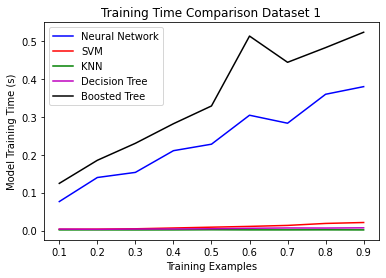

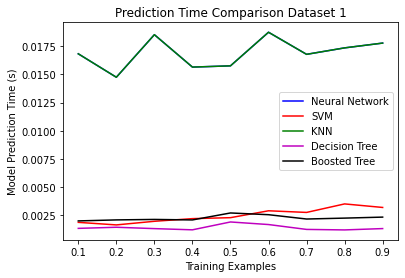

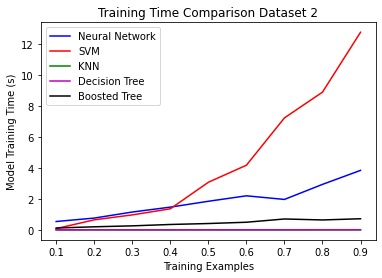

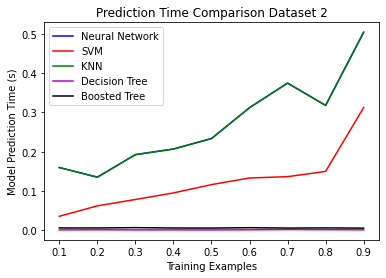

In [26]:
train_sample = np.linspace(0.1, 0.9, 9)
compare_training_time(train_sample, training_times_nn_1, training_times_svm_1, training_times_knn_1,
                 training_times_dt_1, training_times_bt_1, 'Training Time Comparison Dataset 1')              
compare_prediction_time(train_sample, prediction_times_knn_1, prediction_times_svm_1, prediction_times_knn_1, 
                 prediction_times_dt_1, prediction_times_bt_1, 'Prediction Time Comparison Dataset 1')

train_sample = np.linspace(0.1, 0.9, 9)
compare_training_time(train_sample, training_times_nn_2, training_times_svm_2, training_times_knn_2,
                 training_times_dt_2, training_times_bt_2, 'Training Time Comparison Dataset 2')              
compare_prediction_time(train_sample, prediction_times_knn_2, prediction_times_svm_2, prediction_times_knn_2, 
                 prediction_times_dt_2, prediction_times_bt_2, 'Prediction Time Comparison Dataset 2')